# Building cancer-detection system with RadIO

## 1. CT-scans and Lung-cancer

In [4]:
# some imports
from ipywidgets import interact
from plotting_tools import pil_plot_slices
from example import load_example
import os

* CT-scans are 3d-arrays of data. Cancer in lungs is represented in *pulmonary nodules*:

In [6]:
# plot the scan and corresponding mask
PATH_TO_SAMPLE = '/home/alexander/Work/Temp/unrarred/needed/other/_demo_data/scans_sample/'
bch = load_example(path=os.path.join(PATH_TO_SAMPLE,
                                     '1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998'))
num_item = 0
interact(lambda height: pil_plot_slices(height, bch.get(num_item, 'images'), bch.get(num_item, 'masks')),
         height=(0, 0.99, 0.01))

interactive(children=(FloatSlider(value=0.49, description='height', max=0.99, step=0.01), Output()), _dom_clas…

<function __main__.<lambda>(height)>

## 2. Dealing with imperfect annotation

## 3. Building detection system-workflow

### `Dataset` and `Pipeline`

CT-scans are voluminous. It is not possible to store all scans from the dataset in memory at once. In order to work with the dataset of scans, we create `Dataset`: an *indexing strructure*:

In [2]:
import sys
sys.path.append('..')

In [11]:
from radio.dataset import FilesIndex, Dataset, Pipeline
from radio import CTImagesMaskedBatch

LUNA_MASK = '../../../pydata/sample_raw/*.mhd'                     # set glob-mask for scans from Luna-dataset here
luna_index = FilesIndex(path=LUNA_MASK, no_ext=True)               # preparing indexing structure
lunaset = Dataset(index=luna_index, batch_class=CTImagesMaskedBatch)

In [ ]:
luna_index.indices[:3]

Data-processing workflows are called `pipelines`, which represent sequences(plans) of actions on data

To perform some real computation we need to pass a batch through a `pipeline`:

### 3.1 Preprocessing

In [5]:
ANNO_PATH = '../../../pydata/luna/CSVFILES/annotations.csv'

In [6]:
import pandas as pd
nodules_df = pd.read_csv(ANNO_PATH)

In [7]:
preprocessing = ((Pipeline()
                 .load(fmt='raw', components=['images', 'spacing', 'origin'])
                 .fetch_nodules_info(nodules_df)
                 .create_mask()
                 .normalize_hu()
#                  .dump(fmt='blosc', dst='luna/subset_blosc/', components=['images', 'spacing', 'origin', 'masks'])
                ) << lunaset)

In [8]:
# preprocessing = (Pipeline()
#                  .load(fmt='blosc')
#                  .fetch_nodules_info(ANNO_PATH)
#                  .create_mask()
#                  .normalize_hu())

In [9]:
batch = (lunaset >> preprocessing).next_batch(1)

In [10]:
sys.path.append('../tutorials/')

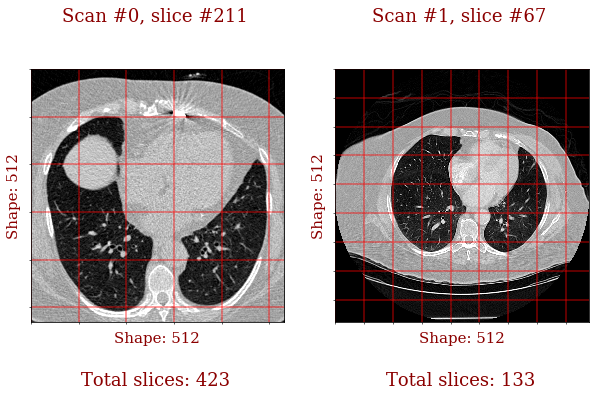

In [11]:
from utils import show_slices
import numpy as np
ixs = np.array(['1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476',
                '1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998'])


two_scans_dataset = Dataset(index=luna_index.create_subset(ixs), batch_class=CTImagesMaskedBatch)
batch = (two_scans_dataset >> preprocessing).next_batch(2, shuffle=False)   # pass a batch through the workflow
show_slices(batch, scan_indices=[0, 1], ns_slice=[211, 67], grid=True, clims=(0, 255))

One can see that the lungs are larger on the left scan. This can be explained by a big difference in scale (represented by a grid). This can be a source of uncontrollable variation in the training dataset. In order to make scans more isotropic, we add action `unify_spacing` to our preprocessing workflow.

In [8]:
SHAPE = (256, 256, 256)
SPACING = (1.7, 1., 1.)

In [ ]:
preprocessing += (Pipeline()
                  .unify_spacing(spacing=SPACING, shape=SHAPE))

Now pass a batch through the workflow and see the difference:

In [ ]:
batch = (two_scans_dataset >> preprocessing).next_batch(2)

In [ ]:
show_slices(batch, scan_indices=[0, 1], ns_slice=[124, 124], grid=True, clims=(0, 255))

### 3.2 Augmentation

Let us add some augmentation actions to the workflow. To begin with, let's *controllably* introduce variation into the scale by randomly zooming in/zooming out on scans:

In [ ]:
spacing_options = [(1.7, 0.5, 0.5), (1.7, 1.0, 1.0), (1.7, 1.5, 1.5), (1.7, 2.0, 2.0)]

here we define spacing randomizer, a function that randomly fetches spacing:

In [9]:
spacing_randomizer = lambda *args: spacing_options[np.random.choice(range(len(spacing_options)))]

In [12]:
from radio.dataset import F                                          # see below the explanation
augmentation = (Pipeline()                                           # empty workflow
                .load(fmt='raw')                                     # load scans
                .unify_spacing(spacing=F(spacing_randomizer), shape=(256, 256, 256)))

add some rotation:

In [17]:
augmentation += (Pipeline()
                 .rotate(random=True, angle=30, components=['images', 'masks']))

### MIPs: a way to reduce 3d-problem to a 2d-one

interact with mips should be here 

In [18]:
augmentation += (Pipeline()
                 .sample_xip(6, 3))

### 3.3 Model training

In [ ]:
import tensorflow as tf
from radio.dataset import B, V, F
from radio.dataset.models.tf import TFModel

model_path = 'unet/e_6_3c_unet/models/logloss/'
config = dict(load=dict(path=model_path),
              session=dict(config=tf.ConfigProto(allow_soft_placement=True)))


SHAPE = (128, 256, 256)
SPACING = (1.7, 1, 1)
XIP_PARAMS = dict(mode='max', depth=6, stride=2, channels=3)

ppl_predict_scan = (Pipeline()
                    .init_model('static', TFModel, 'xipnet', config)
                    .load(fmt='blosc', components=['images', 'spacing', 'origin', 'masks'])
                    .fetch_nodules_from_mask()
                    .init_variables(['predictions', 'nodules_true', 'nodules_predicted'])
                    .fetch_nodules_from_mask()
                    .update_variable('nodules_true', B('nodules'))
                    .predict_model('xipnet', save_to=V('predictions'),
                                   feed_dict=dict(images=F(CTIMB.xip, component='images', **XIP_PARAMS)))
                    .call(CTIMB.unxip, xip=V('predictions'), squeeze=True, **XIP_PARAMS,
                          component='masks')
                    .fetch_nodules_from_mask()
                    .update_variable('nodules_predicted', B('nodules')) << lunaset)
